In [1]:
import os
import re
import sys
import glob
import pickle
import tables
import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if not '..' in sys.path:
    sys.path.append('..')
from train_LSTM import *

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'load-forecasting'

future = 1    # [hours]
history = 24  # [hours]
hours_ahead = np.r_[0 : 24]

base_query = Tag('LSTM') & Tag(f'future={future}') & Tag(f'history={history}')

experiment_IDs = []
val_losses = []
for hours in hours_ahead:
    sys.stdout.write(f'{hours:2.0f} hours ahead ')
    sys.stdout.flush()
    query = base_query & Tag(f'ahead={hours:.1f}')
    experiments = api.query(workspace, project_name, query, archived=False)
    msg = f'({len(experiments)} expts): '
    n_char = len(msg)
    sys.stdout.write(msg)
    min_val_loss = 100
    for experiment in experiments:
        metrics = experiment.get_metrics()
        loss = np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss'])
        if loss.min() < min_val_loss:
            val_loss = loss
            min_val_loss = loss.min()
            tags = experiment.get_tags()
            ID = experiment.id
    experiment_IDs.append(ID)
    val_losses.append(val_loss)
    n_neurons = [int(tag.split('_')[0]) for tag in tags if 'neurons' in tag][0]
    n_layers = [int(tag.split('_')[0]) for tag in tags if 'layers' in tag][0]
    n_epochs = len(val_loss)
    print(f'best expt is {ID[:9]} ({n_layers} layers, {n_neurons} neurons, {n_epochs} epochs), ' + 
          f'validation loss: {min_val_loss:.4f}')

 0 hours ahead (6 expts): best expt is 09e266f9e (3 layers, 20 neurons, 10 epochs), validation loss: 0.0666
 1 hours ahead (6 expts): best expt is 41bb95e38 (2 layers, 20 neurons, 10 epochs), validation loss: 0.1327
 2 hours ahead (6 expts): best expt is 62283c343 (3 layers, 20 neurons, 10 epochs), validation loss: 0.1170
 3 hours ahead (6 expts): best expt is 38b2f5b93 (3 layers, 20 neurons, 10 epochs), validation loss: 0.1450
 4 hours ahead (6 expts): best expt is 81c6a62dd (2 layers, 15 neurons, 10 epochs), validation loss: 0.1519
 5 hours ahead (6 expts): best expt is fae8987f6 (2 layers, 20 neurons, 10 epochs), validation loss: 0.1452
 6 hours ahead (6 expts): best expt is a0fff0a92 (3 layers, 20 neurons, 10 epochs), validation loss: 0.1393
 7 hours ahead (6 expts): best expt is 17df42b02 (3 layers, 20 neurons, 10 epochs), validation loss: 0.1426
 8 hours ahead (6 expts): best expt is 556b8948a (3 layers, 20 neurons, 10 epochs), validation loss: 0.1427
 9 hours ahead (6 expts): be

In [3]:
experiments_path = '../experiments/LSTM/'
n_experiments = len(experiment_IDs)
training_set_min = []
training_set_max = []
models = []
for i,experiment_ID in enumerate(experiment_IDs):
    checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
    checkpoint_files = glob.glob(checkpoint_path + '*.h5')
    epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0])
              for file in checkpoint_files]
    best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_losses[i]) + 1)]
    models.append(keras.models.load_model(best_checkpoint, compile=True))

parameters = pickle.load(open(experiments_path + experiment_ID + '/parameters.pkl', 'rb'))
# we need min and max of the training set to normalize the data
training_set_min = parameters['training_set_min']
training_set_max = parameters['training_set_max']
data_file = '../' + parameters['data_file']
time_step = parameters['time_step']

In [4]:
data = pickle.load(open(data_file, 'rb'))
df = data['full']['building_energy']
orig_time_step = extract_time_step(df)
df = add_minute_and_workday(df)
df = average_data(df, time_step, orig_time_step, ['consumption', 'generation'])
n_days, samples_per_day = compute_stats(df, time_step)
t = np.arange(samples_per_day) * time_step / 60

print(f'Time step: {time_step} minutes.')
print(f'Number of days: {n_days}.')
print(f'Samples per day: {samples_per_day}.')

Time step: 15 minutes.
Number of days: 365.
Samples per day: 96.


In [5]:
cols = parameters['inputs']['continuous']
if parameters['average_continuous_inputs']:
    cols = [col + '_averaged' for col in cols]
X = make_dataset(df, cols, parameters['inputs']['categorical'],
                training_set_max, training_set_min, n_days, samples_per_day)

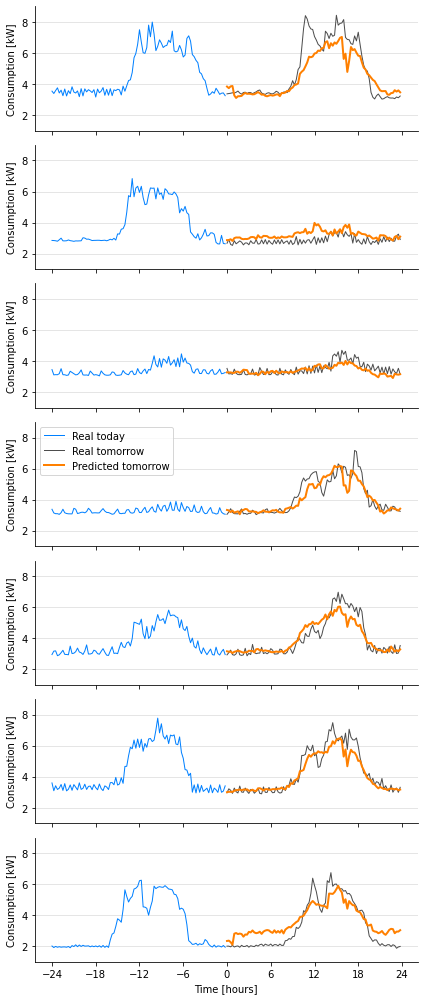

In [8]:
fun = lambda y,M,m: (m + (M - m) / 2 * (y + 1)) * 1e-3
offsets = range(30, 365, 50)
n_offsets = len(offsets)
fig,ax = plt.subplots(n_offsets, 1, figsize=(6, n_offsets * 2), sharex=True)
max_today = 100
for i,offset in enumerate(offsets):
    start = offset * samples_per_day
    stop = (offset + 1) * samples_per_day
    today = tf.constant(X[start : stop, :][np.newaxis, :, :], dtype=tf.float32)
    tomorrow = np.ndarray.flatten(np.concatenate([model.predict(today) for model in models]))
    
    today_actual = fun(today[0,:,0], training_set_max[0], training_set_min[0])
    tomorrow_predicted = fun(tomorrow, training_set_max[0], training_set_min[0])
    tomorrow_actual = fun(X[start + samples_per_day : stop + samples_per_day, 0],
                         training_set_max[0], training_set_min[0])
    
    if np.max(today_actual) < max_today:
        max_today = np.max(today_actual)
        j = i
    ax[i].plot(t - 24, today_actual, color=[0,.5,1], lw=1, label='Real today')
    ax[i].plot(t, tomorrow_actual, color=[.3,.3,.3], lw=1, label='Real tomorrow')
    ax[i].plot(t, tomorrow_predicted, color=[1,.5,0], lw=2, label='Predicted tomorrow')
ax[j].legend(loc='upper left')
for a in ax:
    a.set_ylabel('Consumption [kW]')
    a.set_ylim([1, 9])
    a.grid(True, which='major', axis='y', color=[.8,.8,.8], linestyle='-', linewidth=0.5)
    for side in 'top','right':
        a.spines[side].set_visible(False)
ax[-1].set_xlabel('Time [hours]')
ax[-1].set_xticks(np.r_[-24 : 25 : 6])
fig.tight_layout()